In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()
#create directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permisions of the file
!chmod 600 ~/.kaggle/kaggle.json
#download the dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database --force

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 776M/778M [00:06<00:00, 235MB/s]
100% 778M/778M [00:06<00:00, 132MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "covid19-radiography-database.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


In [ ]:
!pip install split-folders
import os
import shutil

source_dir = "/content/COVID-19_Radiography_Dataset"

# Iterate over each class directory
for class_dir in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_dir)
    images_path = os.path.join(class_path, 'images')  # Specific subfolder to focus on

    if os.path.isdir(images_path):
        # Move each file in the 'images' subfolder to the class directory
        for filename in os.listdir(images_path):
            source_file = os.path.join(images_path, filename)
            target_file = os.path.join(class_path, filename)
            if os.path.isfile(source_file):
                shutil.move(source_file, target_file)
        # Optionally, remove the now empty 'images' subfolder
        os.rmdir(images_path)
import splitfolders as sf
input_folder = "/content/COVID-19_Radiography_Dataset"
output = "/content/split_dataset4"
#where you want the split datasets saved. one will be created if none is set

sf.ratio(input_folder, output=output, seed=42, ratio=(.8, .0,.2))
#train ,val,test

Copying files: 21165 files [00:06, 3309.12 files/s]


In [ ]:
import keras,os
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/split_dataset4/train",target_size=(224,224), class_mode='categorical')

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/split_dataset4/test", target_size=(224,224), class_mode='categorical')

Found 16930 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [ ]:
x_batch, y_batch = next(traindata)
print("Batch image size:", x_batch.shape)

Batch image size: (32, 224, 224, 3)


In [ ]:
#vgg16
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [ ]:
for layers in (model.layers)[:19]:
  print(layers)
  layers.trainable = False

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/bestweights/vgg16_1.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', save_freq=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')


hist = model.fit(
    x=traindata,
    validation_data=testdata,
    epochs=50,
    steps_per_epoch=5,
    validation_steps=1,
    callbacks=[checkpoint, early]
)

Epoch 1/50


1/5 [=====>........................] - ETA: 4:34 - loss: 1.5088 - accuracy: 0.1562

2/5 [===========>..................] - ETA: 2:59 - loss: 4364.6128 - accuracy: 0.3281

3/5 [=================>............] - ETA: 2:02 - loss: 2910.2458 - accuracy: 0.3021

4/5 [=======================>......] - ETA: 1:01 - loss: 2183.0295 - accuracy: 0.2812

5/5 [==============================] - 335s 67s/step - loss: 1746.6615 - accuracy: 0.3313 - val_loss: 12.6729 - val_accuracy: 0.4375
Epoch 2/50


1/5 [=====>........................] - ETA: 4:04 - loss: 10.6956 - accuracy: 0.5625

2/5 [===========>..................] - ETA: 3:14 - loss: 6.1492 - accuracy: 0.3750 

3/5 [=================>............] - ETA: 2:05 - loss: 4.5699 - accuracy: 0.2917

4/5 [=======================>......] - ETA: 1:02 - loss: 3.7713 - accuracy: 0.2578

5/5 [==============================] - 327s 67s/step - loss: 3.2923 - accuracy: 0.2688 - val_loss: 1.3744 - val_accuracy: 0.3125
Epoch 3/50


1/5 [=====>........................] - ETA: 3:57 - loss: 1.3816 - accuracy: 0.2500

2/5 [===========>..................] - ETA: 3:05 - loss: 1.3776 - accuracy: 0.2969

3/5 [=================>............] - ETA: 2:07 - loss: 1.3756 - accuracy: 0.3125

4/5 [=======================>......] - ETA: 1:02 - loss: 1.3848 - accuracy: 0.2734

5/5 [==============================] - 329s 67s/step - loss: 1.3748 - accuracy: 0.3187 - val_loss: 1.1853 - val_accuracy: 0.3125
Epoch 4/50


1/5 [=====>........................] - ETA: 4:11 - loss: 1.2365 - accuracy: 0.3438

2/5 [===========>..................] - ETA: 3:00 - loss: 1.7260 - accuracy: 0.3750

3/5 [=================>............] - ETA: 2:00 - loss: 1.5741 - accuracy: 0.3646

4/5 [=======================>......] - ETA: 1:00 - loss: 1.5220 - accuracy: 0.3359

5/5 [==============================] - 328s 66s/step - loss: 1.4881 - accuracy: 0.3375 - val_loss: 1.3442 - val_accuracy: 0.3438
Epoch 5/50


1/5 [=====>........................] - ETA: 4:23 - loss: 1.3342 - accuracy: 0.3125

2/5 [===========>..................] - ETA: 3:03 - loss: 1.3406 - accuracy: 0.3281

3/5 [=================>............] - ETA: 2:01 - loss: 1.3452 - accuracy: 0.2812

4/5 [=======================>......] - ETA: 1:01 - loss: 1.3380 - accuracy: 0.2969

5/5 [==============================] - 331s 66s/step - loss: 1.3365 - accuracy: 0.3063 - val_loss: 1.3060 - val_accuracy: 0.4375
Epoch 6/50


1/5 [=====>........................] - ETA: 4:04 - loss: 1.3051 - accuracy: 0.3438

2/5 [===========>..................] - ETA: 2:59 - loss: 1.3224 - accuracy: 0.3125

3/5 [=================>............] - ETA: 2:02 - loss: 1.3216 - accuracy: 0.2708

4/5 [=======================>......] - ETA: 1:00 - loss: 1.3154 - accuracy: 0.2734

5/5 [==============================] - 326s 66s/step - loss: 1.3070 - accuracy: 0.2750 - val_loss: 1.2708 - val_accuracy: 0.4688
Epoch 7/50


1/5 [=====>........................] - ETA: 4:07 - loss: 1.2852 - accuracy: 0.2500

2/5 [===========>..................] - ETA: 3:09 - loss: 1.3044 - accuracy: 0.2656

3/5 [=================>............] - ETA: 2:03 - loss: 1.2963 - accuracy: 0.2604

4/5 [=======================>......] - ETA: 1:01 - loss: 1.2817 - accuracy: 0.2500

5/5 [==============================] - 328s 66s/step - loss: 1.2629 - accuracy: 0.2625 - val_loss: 1.0225 - val_accuracy: 0.5625
Epoch 8/50


1/5 [=====>........................] - ETA: 4:15 - loss: 1.3038 - accuracy: 0.2812

2/5 [===========>..................] - ETA: 3:01 - loss: 1.2102 - accuracy: 0.3594

3/5 [=================>............] - ETA: 2:01 - loss: 1.1948 - accuracy: 0.4375

4/5 [=======================>......] - ETA: 1:00 - loss: 1.2063 - accuracy: 0.4453

5/5 [==============================] - 326s 66s/step - loss: 1.2215 - accuracy: 0.4375 - val_loss: 1.0829 - val_accuracy: 0.5938
Epoch 9/50


1/5 [=====>........................] - ETA: 4:05 - loss: 1.2607 - accuracy: 0.4375

2/5 [===========>..................] - ETA: 2:58 - loss: 1.2676 - accuracy: 0.4062

3/5 [=================>............] - ETA: 2:00 - loss: 1.2340 - accuracy: 0.4479

4/5 [=======================>......] - ETA: 1:00 - loss: 1.2256 - accuracy: 0.4688

5/5 [==============================] - 323s 65s/step - loss: 1.2029 - accuracy: 0.4812 - val_loss: 1.1456 - val_accuracy: 0.5000
Epoch 10/50


1/5 [=====>........................] - ETA: 4:06 - loss: 1.1436 - accuracy: 0.5312

2/5 [===========>..................] - ETA: 2:58 - loss: 1.1947 - accuracy: 0.4844

3/5 [=================>............] - ETA: 2:01 - loss: 1.2742 - accuracy: 0.4167

4/5 [=======================>......] - ETA: 1:00 - loss: 1.2296 - accuracy: 0.4531

5/5 [==============================] - 324s 66s/step - loss: 1.2347 - accuracy: 0.4563 - val_loss: 1.1149 - val_accuracy: 0.5938
Epoch 11/50


1/5 [=====>........................] - ETA: 4:08 - loss: 1.1731 - accuracy: 0.5312

2/5 [===========>..................] - ETA: 3:10 - loss: 1.2263 - accuracy: 0.4844

3/5 [=================>............] - ETA: 2:03 - loss: 1.2186 - accuracy: 0.4792

4/5 [=======================>......] - ETA: 1:01 - loss: 1.2256 - accuracy: 0.4688

5/5 [==============================] - 326s 66s/step - loss: 1.2227 - accuracy: 0.4688 - val_loss: 0.9985 - val_accuracy: 0.6875
Epoch 12/50


1/5 [=====>........................] - ETA: 4:01 - loss: 1.0795 - accuracy: 0.5938

2/5 [===========>..................] - ETA: 2:56 - loss: 1.2606 - accuracy: 0.5312

3/5 [=================>............] - ETA: 1:59 - loss: 1.2619 - accuracy: 0.4896

4/5 [=======================>......] - ETA: 1:00 - loss: 1.2470 - accuracy: 0.5078

5/5 [==============================] - 318s 64s/step - loss: 1.2138 - accuracy: 0.5375 - val_loss: 1.2610 - val_accuracy: 0.4375
Epoch 13/50


1/5 [=====>........................] - ETA: 3:57 - loss: 1.1759 - accuracy: 0.4688

2/5 [===========>..................] - ETA: 3:00 - loss: 1.1572 - accuracy: 0.5156

3/5 [=================>............] - ETA: 1:59 - loss: 1.1627 - accuracy: 0.5000

4/5 [=======================>......] - ETA: 1:00 - loss: 1.1738 - accuracy: 0.4922

5/5 [==============================] - 321s 65s/step - loss: 1.1846 - accuracy: 0.4938 - val_loss: 1.1583 - val_accuracy: 0.5312
Epoch 14/50


1/5 [=====>........................] - ETA: 3:58 - loss: 1.4398 - accuracy: 0.4375

2/5 [===========>..................] - ETA: 3:01 - loss: 1.3154 - accuracy: 0.4219

3/5 [=================>............] - ETA: 2:01 - loss: 1.1954 - accuracy: 0.5208

4/5 [=======================>......] - ETA: 1:00 - loss: 1.1794 - accuracy: 0.5000

5/5 [==============================] - 320s 65s/step - loss: 1.1853 - accuracy: 0.5063 - val_loss: 1.1827 - val_accuracy: 0.4688
Epoch 15/50


1/5 [=====>........................] - ETA: 4:00 - loss: 1.3715 - accuracy: 0.3125

2/5 [===========>..................] - ETA: 3:07 - loss: 1.2799 - accuracy: 0.3750

3/5 [=================>............] - ETA: 2:02 - loss: 1.2558 - accuracy: 0.4167

4/5 [=======================>......] - ETA: 1:01 - loss: 1.2123 - accuracy: 0.4531

5/5 [==============================] - 322s 66s/step - loss: 1.2102 - accuracy: 0.4563 - val_loss: 1.1915 - val_accuracy: 0.5312
Epoch 16/50


1/5 [=====>........................] - ETA: 4:05 - loss: 1.3776 - accuracy: 0.3125

2/5 [===========>..................] - ETA: 3:04 - loss: 1.3780 - accuracy: 0.3594

3/5 [=================>............] - ETA: 2:03 - loss: 1.2677 - accuracy: 0.4167

4/5 [=======================>......] - ETA: 1:01 - loss: 1.2876 - accuracy: 0.4141

5/5 [==============================] - 325s 66s/step - loss: 1.2716 - accuracy: 0.4313 - val_loss: 1.2130 - val_accuracy: 0.4375
Epoch 17/50


1/5 [=====>........................] - ETA: 3:59 - loss: 1.1531 - accuracy: 0.5625

2/5 [===========>..................] - ETA: 2:59 - loss: 1.1230 - accuracy: 0.5000

3/5 [=================>............] - ETA: 1:58 - loss: 1.1396 - accuracy: 0.5000

4/5 [=======================>......] - ETA: 1:01 - loss: 1.1659 - accuracy: 0.5000

5/5 [==============================] - 323s 66s/step - loss: 1.1525 - accuracy: 0.4938 - val_loss: 1.2591 - val_accuracy: 0.4062
Epoch 18/50


1/5 [=====>........................] - ETA: 3:58 - loss: 1.3155 - accuracy: 0.3438

2/5 [===========>..................] - ETA: 2:55 - loss: 1.2286 - accuracy: 0.4062

3/5 [=================>............] - ETA: 1:58 - loss: 1.2571 - accuracy: 0.3750

4/5 [=======================>......] - ETA: 58s - loss: 1.2604 - accuracy: 0.3672 

5/5 [==============================] - 317s 64s/step - loss: 1.2774 - accuracy: 0.3750 - val_loss: 1.0769 - val_accuracy: 0.5625
Epoch 19/50


1/5 [=====>........................] - ETA: 3:58 - loss: 1.1830 - accuracy: 0.5625

2/5 [===========>..................] - ETA: 2:59 - loss: 1.1774 - accuracy: 0.5781

3/5 [=================>............] - ETA: 1:58 - loss: 1.2130 - accuracy: 0.5729

4/5 [=======================>......] - ETA: 1:01 - loss: 1.2815 - accuracy: 0.5000

5/5 [==============================] - 319s 65s/step - loss: 1.2662 - accuracy: 0.4875 - val_loss: 1.1889 - val_accuracy: 0.5312
Epoch 20/50


1/5 [=====>........................] - ETA: 3:57 - loss: 1.1439 - accuracy: 0.5000

2/5 [===========>..................] - ETA: 2:58 - loss: 1.2223 - accuracy: 0.4688

3/5 [=================>............] - ETA: 1:59 - loss: 1.2387 - accuracy: 0.4375

4/5 [=======================>......] - ETA: 59s - loss: 1.2075 - accuracy: 0.4688 

5/5 [==============================] - 314s 64s/step - loss: 1.2250 - accuracy: 0.4563 - val_loss: 1.1711 - val_accuracy: 0.6250
Epoch 21/50


1/5 [=====>........................] - ETA: 4:02 - loss: 1.2474 - accuracy: 0.4375

2/5 [===========>..................] - ETA: 2:57 - loss: 1.2400 - accuracy: 0.4531

3/5 [=================>............] - ETA: 2:04 - loss: 1.1409 - accuracy: 0.5833

4/5 [=======================>......] - ETA: 1:01 - loss: 1.1371 - accuracy: 0.5781

5/5 [==============================] - 325s 66s/step - loss: 1.1630 - accuracy: 0.5500 - val_loss: 1.1296 - val_accuracy: 0.5625
Epoch 22/50


1/5 [=====>........................] - ETA: 3:55 - loss: 1.1669 - accuracy: 0.4688

2/5 [===========>..................] - ETA: 2:58 - loss: 1.1348 - accuracy: 0.5312

3/5 [=================>............] - ETA: 1:58 - loss: 1.1348 - accuracy: 0.5417

4/5 [=======================>......] - ETA: 59s - loss: 1.1729 - accuracy: 0.5000 

5/5 [==============================] - 313s 64s/step - loss: 1.1516 - accuracy: 0.5125 - val_loss: 1.2167 - val_accuracy: 0.4062
Epoch 23/50


1/5 [=====>........................] - ETA: 3:54 - loss: 1.1935 - accuracy: 0.5000

2/5 [===========>..................] - ETA: 3:11 - loss: 1.1260 - accuracy: 0.5156

3/5 [=================>............] - ETA: 2:04 - loss: 1.0838 - accuracy: 0.5417

4/5 [=======================>......] - ETA: 1:00 - loss: 1.0939 - accuracy: 0.5469

5/5 [==============================] - 321s 66s/step - loss: 1.1124 - accuracy: 0.5312 - val_loss: 1.1576 - val_accuracy: 0.5625
Epoch 24/50


1/5 [=====>........................] - ETA: 4:06 - loss: 0.9969 - accuracy: 0.5938

2/5 [===========>..................] - ETA: 3:00 - loss: 1.0961 - accuracy: 0.5312

3/5 [=================>............] - ETA: 1:58 - loss: 1.0663 - accuracy: 0.5625

4/5 [=======================>......] - ETA: 59s - loss: 1.1628 - accuracy: 0.5078 

5/5 [==============================] - 317s 64s/step - loss: 1.1945 - accuracy: 0.4875 - val_loss: 1.1331 - val_accuracy: 0.5000
Epoch 25/50


1/5 [=====>........................] - ETA: 3:55 - loss: 1.4505 - accuracy: 0.4062

2/5 [===========>..................] - ETA: 3:00 - loss: 1.4214 - accuracy: 0.3906

3/5 [=================>............] - ETA: 1:58 - loss: 1.3258 - accuracy: 0.4583

4/5 [=======================>......] - ETA: 59s - loss: 1.2941 - accuracy: 0.4531 

5/5 [==============================] - 314s 64s/step - loss: 1.2601 - accuracy: 0.4625 - val_loss: 1.0139 - val_accuracy: 0.6875
Epoch 26/50


1/5 [=====>........................] - ETA: 3:57 - loss: 1.3347 - accuracy: 0.5000

2/5 [===========>..................] - ETA: 2:59 - loss: 1.2396 - accuracy: 0.4688

3/5 [=================>............] - ETA: 1:58 - loss: 1.2297 - accuracy: 0.4583

4/5 [=======================>......] - ETA: 59s - loss: 1.2335 - accuracy: 0.4609 

5/5 [==============================] - 315s 64s/step - loss: 1.1926 - accuracy: 0.5063 - val_loss: 1.1295 - val_accuracy: 0.5625
Epoch 26: early stopping


In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

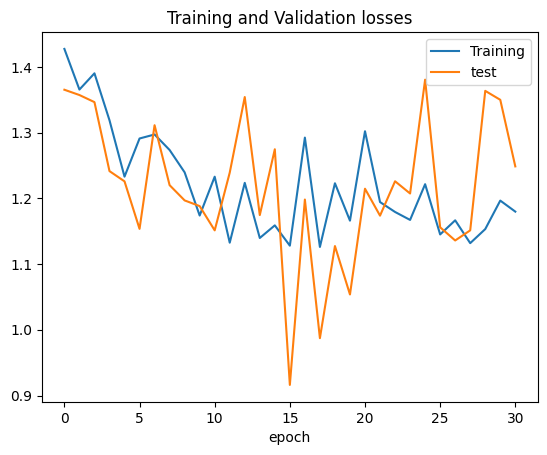

In [ ]:
hist.history.keys()
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'test'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

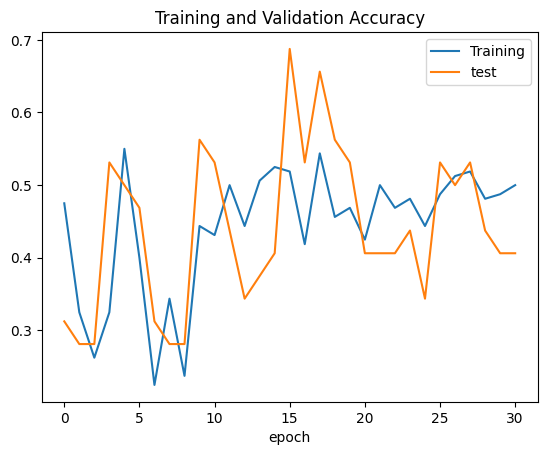

In [ ]:
hist.history.keys()
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'test'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

In [ ]:
#Load the weights
model.load_weights("/content/bestweights/vgg16_1.h5")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/vgg16_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np



# Get predictions for the test data
y_pred = model.predict(testdata)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = testdata.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


KeyboardInterrupt: 